# Library

In [29]:
# general
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import re

# Visualization
from wordcloud import WordCloud

# NLP
import nltk
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from symspellpy import SymSpell, Verbosity

# Text Processing

from operator import itemgetter

# extras
from tqdm import tqdm


In [3]:
df = pd.read_csv('D:\Coding\school\\thesis dhewa\scraping\sample1k-review_dataset-020225.csv')
df.head()

,Unnamed: 0,reviewId,content,score,at,replyContent,appVersion,application
0,83368,85d3e765-c7e8-4d15-be91-90b124893c85,Menyenangkan🥰,5,2022-06-30 16:01:21,"Hi Mums, Terima kasih telah menggunakan Teman ...",2.9.2,Teman Bumil
1,43673,edabddf1-7ed6-42b2-830e-32160ccf3bff,Syukaa,5,2020-06-07 21:30:30,"Hai, Parent! Terima kasih atas review positifn...",2.6.17,Asian Parent
2,72119,8aab4534-f359-4b19-b4da-a21ee6bc4a4b,Mentok mulu di PIN stiap mau log in ga bisa ms...,1,2024-09-10 10:48:01,"Hallo Mama Rika Komalasari, kami sangat menger...",2.5.5,Hallobumil
3,80274,10f8f8a7-a82d-4586-8d4e-15b3a6c23a67,Aplikasi sangat membantu saya yang lagi hamil ...,5,2023-08-28 21:21:06,"Hi Mums, Terima kasih telah menggunakan Teman ...",2.19.8,Teman Bumil
4,34588,14a13395-262f-494d-bca6-4173508c4511,Solusi ibu hamil,5,2021-02-26 17:38:04,"Hai, Parent! Terima kasih atas review positifn...",2.8.2,Asian Parent


## Filter after 2021

In [4]:
df["at"] = pd.to_datetime(df["at"])
df_aft_covid = df[df["at"].dt.year >= 2021]

In [5]:
df_bef_covid = df[df["at"].dt.year <= 2021]

In [6]:
df_aft_covid.count()

Unnamed: 0      6066
reviewId        6066
content         6066
score           6066
at              6066
replyContent    5725
appVersion      5320
application     6066
dtype: int64

In [7]:
df_aft_covid.to_csv('D:/Coding/school/thesis dhewa/scraping/sample1k-covid_review_dataset-020225.csv')

In [8]:
df_aft_covid_bad = df_aft_covid[df_aft_covid["score"] <= 3]
df_aft_covid_bad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 2 to 9855
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    321 non-null    int64         
 1   reviewId      321 non-null    object        
 2   content       321 non-null    object        
 3   score         321 non-null    int64         
 4   at            321 non-null    datetime64[ns]
 5   replyContent  312 non-null    object        
 6   appVersion    242 non-null    object        
 7   application   321 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 22.6+ KB


In [9]:
df_aft_covid_bad.to_csv('D:/Coding/school/thesis dhewa/scraping/sample1k-bad_review_dataset-020225.csv')

In [10]:
df_aft_covid = df_aft_covid_bad

In [11]:
df_aft_covid = df_aft_covid[['content']].copy()
df_aft_covid.rename(columns={'content': 'review'}, inplace=True)

In [12]:
df_aft_covid.head()

,review
2,Mentok mulu di PIN stiap mau log in ga bisa ms...
14,Baru mau coba kalu bangus yah tak kasih 5
43,Loading splash screennya lama. Harus restart H...
89,Rubbish
127,So many rules!! So difficult for sharing!


# Preprocessing

In [13]:
df_aft_covid = df_aft_covid[['review']].copy().astype(str)

## Drop Duplicates

> This meant to delete words that are lot of them are duplicated such as "bagus, nice, good, mantab sekali, etc"

In [14]:
df_aft_covid = df_aft_covid.drop_duplicates()
print(f'Reviews left after drop duplicated: {df_aft_covid.count()} reviews')

Reviews left after drop duplicated: review    316
dtype: int64 reviews


In [15]:
df_aft_covid

,review
2,Mentok mulu di PIN stiap mau log in ga bisa ms...
14,Baru mau coba kalu bangus yah tak kasih 5
43,Loading splash screennya lama. Harus restart H...
89,Rubbish
127,So many rules!! So difficult for sharing!
...,...
9836,Knp hrus d update??
9840,"Tiap saat update, bagusan yg awal². Lebih nnyaman"
9844,Baru nyoba
9851,Ga bisa di instal


## Sentence Level Preprocessing

### Case Folding

In [238]:
def indonesian_case_folding(s):
    """
    Preprocessing teks dalam bahasa Indonesia
    """

    # lower the text
    s = s.lower()

    # Delete html entitiy such as "&gt;" atau "&lt;"
    s = re.sub(r'&gt|&lt', ' ', s)

    # Normalizing repetitive words (ex: "bagusss" -> "bagus")
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)

    # Normalizing repetitive character (ex: "!!!" -> "!")
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)

    # Add space after punctuation
    s = re.sub(f"([{re.escape(string.punctuation)}])(\w)", r"\1 \2", s)

    # Remove punctuation
    s = s.translate(str.maketrans('', '', string.punctuation))

    # Remove inside bracket text
    s = re.sub(r'\(.*?\)', '. ', s)

    # Remove noise
    # s = re.sub(r'product received for free[.| ]', ' ', s)

    # Remove emojis and special character
    s = re.sub(r'[^\w\s.,!?]', '', s)

    return s.strip()

In [239]:
df_aft_covid["processed_review"] = df_aft_covid['review'].apply(indonesian_case_folding)
df_aft_covid.head()

,review,processed_review
2,Mentok mulu di PIN stiap mau log in ga bisa ms...,mentok mulu di pin stiap mau log in ga bisa ms...
14,Baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalu bangus yah tak kasih 5
43,Loading splash screennya lama. Harus restart H...,loading splash screennya lama harus restart hp...
89,Rubbish,rubbish
127,So many rules!! So difficult for sharing!,so many rules so difficult for sharing


## Word Level Preprocessing

### Spelling Check

To create a spelling checker we may need a corpus / a dictionary that contains Indonesian words as reference. 
The easiest way is to scrape from the available resources online

In [42]:
# initialize
sym_spell = SymSpell()

# create dictionary
path_corpus = "D:/Coding/school/thesis dhewa/preprocessing/resources/clean_wordlist.txt"
sym_spell.create_dictionary(path_corpus, encoding="utf-8")

True

In [43]:
suggestions = sym_spell.lookup('hmil',
                               Verbosity.CLOSEST,
                               max_edit_distance=2,
                               include_unknown=True)
for s in suggestions:
    print(s.term, s.count)

hamil 6
mil 4
amil 3
hail 2
kmil 1


### Fix slang words

In [240]:
# first dictionary - "new_kamusalay.csv"
alay_dict = pd.read_csv(
    'D:/Coding/school/thesis dhewa/preprocessing/resources/new_kamusalay.csv',
    names=['original', 'replacement'],  # Set column names manually
    encoding='latin-1'
)

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

In [241]:
# second dictionary - "combined_slang_words.txt"
with open('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_slang_words.txt', 'r', encoding='utf-8') as file:
    slang_dict_txt = json.load(file)

In [242]:
# merge both dictionary and function
combined_slang_dict = {**alay_dict_map, **slang_dict_txt}

def normalize_slang(text):
    words = text.split()
    normalized_text = ' '.join([combined_slang_dict.get(word, word) for word in words])
    return normalized_text

In [243]:
df_aft_covid['processed_words'] = df_aft_covid['processed_review'].apply(normalize_slang)
df_aft_covid[df_aft_covid['processed_review'] != df_aft_covid['processed_words']].sample(5)

,review,processed_review,processed_words
7195,aplikasi gak bermutu diminta verifikasi akun v...,aplikasi gak bermutu diminta verifikasi akun v...,aplikasi tidak bermutu diminta verifikasi akun...
1202,Kembalikan hallobumil yg lama😌,kembalikan hallobumil yg lama,kembalikan hallobumil yang lama
3860,Mengapa ya ketika mau dibuka aplikasinya ada k...,mengapa ya ketika mau dibuka aplikasinya ada k...,mengapa iya ketika mau dibuka aplikasinya ada ...
6400,"Setelah update, datanya hilang semua",setelah update datanya hilang semua,setelah pembaruan datanya hilang semua
3310,SEMAKIN BURUK SETELAH DI UPGRADE. Data hilang ...,semakin buruk setelah di upgrade data hilang s...,semakin buruk setelah di peningkatan data hila...


In [244]:
df_aft_covid.tail(1)

,review,processed_review,processed_words
9855,what happened with the app? i already reinstal...,what happened with the app i already reinstall...,apa happened dengan the app i already reinstal...


it even fix the "bumil" to a normalize "ibu hamil" ANJAAAAAYYYYYYYYYYYYYY

### Tokenize Text

In [245]:
tokenizer = TreebankWordTokenizer()

# apply
df_aft_covid['tokenized_words'] = df_aft_covid['processed_words'].apply(tokenizer.tokenize)

In [246]:
df_aft_covid.head()

,review,processed_review,processed_words,tokenized_words
2,Mentok mulu di PIN stiap mau log in ga bisa ms...,mentok mulu di pin stiap mau log in ga bisa ms...,mentok melulu di pin setiap mau log in tidak b...,"[mentok, melulu, di, pin, setiap, mau, log, in..."
14,Baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalau bangus ya tidak kasih 5,"[baru, mau, coba, kalau, bangus, ya, tidak, ka..."
43,Loading splash screennya lama. Harus restart H...,loading splash screennya lama harus restart hp...,loading splash screennya lama harus restart ha...,"[loading, splash, screennya, lama, harus, rest..."
89,Rubbish,rubbish,rubbish,[rubbish]
127,So many rules!! So difficult for sharing!,so many rules so difficult for sharing,sok many rules sok difficult for sharing,"[sok, many, rules, sok, difficult, for, sharing]"


### Stemming

In [247]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stem_factory = factory.get_words()

In [248]:
# add more words from "combined_root_words.txt"
with open('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_root_words.txt', 'r', encoding='utf-8') as f:
    root_words = f.read().splitlines()
    
all_root_words = list(set(stem_factory + root_words))

In [249]:
def custom_stem(word):
    if word in all_root_words:
        return word 
    return stemmer.stem(word)

In [250]:
# apply
tqdm.pandas() 
df_aft_covid['processed_tokenized'] = df_aft_covid['tokenized_words'].progress_apply(
    lambda words: [custom_stem(word) for word in words]
)

df_aft_covid[['tokenized_words', 'processed_tokenized']][df_aft_covid['tokenized_words'] != df_aft_covid['processed_tokenized']].sample(5)

  0%|          | 0/316 [00:00<?, ?it/s]

100%|██████████| 316/316 [01:02<00:00,  5.04it/s]


,tokenized_words,processed_tokenized
7500,"[aplikasi, ini, cukup, membantu]","[aplikasi, ini, cukup, bantu]"
6510,"[setelah, pembaruan, kok, bahkan, balik, dafta...","[telah, baru, kok, bahkan, balik, daftar, baru..."
6269,"[saya, mau, gunakan, fitur, live, chat, sama, ...","[saya, mau, guna, fitur, live, chat, sama, dok..."
327,"[semoga, membabtu]","[moga, membabtu]"
3314,"[semoga, dapat, membantu, saya]","[moga, dapat, bantu, saya]"


In [251]:
df_aft_covid.head()

,review,processed_review,processed_words,tokenized_words,processed_tokenized
2,Mentok mulu di PIN stiap mau log in ga bisa ms...,mentok mulu di pin stiap mau log in ga bisa ms...,mentok melulu di pin setiap mau log in tidak b...,"[mentok, melulu, di, pin, setiap, mau, log, in...","[mentok, melulu, di, pin, tiap, mau, log, in, ..."
14,Baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalau bangus ya tidak kasih 5,"[baru, mau, coba, kalau, bangus, ya, tidak, ka...","[baru, mau, coba, kalau, bangus, ya, tidak, ka..."
43,Loading splash screennya lama. Harus restart H...,loading splash screennya lama harus restart hp...,loading splash screennya lama harus restart ha...,"[loading, splash, screennya, lama, harus, rest...","[loading, splash, screennya, lama, harus, rest..."
89,Rubbish,rubbish,rubbish,[rubbish],[rubbish]
127,So many rules!! So difficult for sharing!,so many rules so difficult for sharing,sok many rules sok difficult for sharing,"[sok, many, rules, sok, difficult, for, sharing]","[sok, many, rules, sok, difficult, for, sharing]"


### Stopwords

In [163]:
# Load stopwords file
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    return stop_words

# Remove stopwords from tokenized lists
def remove_stopwords(tokenized_text, stop_words):
    """Remove stopwords from a tokenized list of words."""
    return [word for word in tokenized_text if word not in stop_words]

In [168]:
# Load stopwords
stop_words = load_stopwords('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_stop_words.txt')

# apply
df_aft_covid['processed_tokenized'] = df_aft_covid['processed_tokenized'].progress_apply(lambda text: remove_stopwords(text, stop_words))

df_aft_covid.head()

  0%|          | 0/4816 [00:00<?, ?it/s]

100%|██████████| 4816/4816 [00:00<?, ?it/s]


,review,processed_review,processed_words,tokenized_words,processed_tokenized
0,Menyenangkan🥰,menyenangkan,menyenangkan,[menyenangkan],[senang]
2,Mentok mulu di PIN stiap mau log in ga bisa ms...,mentok mulu di pin stiap mau log in ga bisa ms...,mentok mulu pin stiap log in ga msuk trus,"[mentok, melulu, di, pin, setiap, mau, log, in...","[mentok, melulu, pin, log, in, masuk]"
3,Aplikasi sangat membantu saya yang lagi hamil ...,aplikasi sangat membantu saya yang lagi hamil ...,aplikasi hamil dalam memantau tumbuh kembang j...,"[aplikasi, sangat, membantu, saya, yang, lagi,...","[aplikasi, bantu, hamil, dalam, pantau, tumbuh..."
4,Solusi ibu hamil,solusi ibu hamil,solusi ibu hamil,"[solusi, ibu, hamil]","[solusi, ibu, hamil]"
5,"aplikasi parenting terlengkap,dan terbaik di i...",aplikasi parenting terlengkap dan terbaik di i...,aplikasi parenting terlengkap terbaik indonesi...,"[aplikasi, parenting, terlengkap, dan, terbaik...","[aplikasi, parenting, lengkap, indonesia, renc..."


## Create Corpus

In [252]:
corpus = []

for row in tqdm(range(len(df_aft_covid['processed_tokenized']))):
    for word in df_aft_covid['processed_tokenized'].iloc[row]:
        corpus.append(word)

corpus[0:20]

100%|██████████| 316/316 [00:00<?, ?it/s]


['mentok',
 'melulu',
 'di',
 'pin',
 'tiap',
 'mau',
 'log',
 'in',
 'tidak',
 'bisa',
 'masuk',
 'terus',
 'baru',
 'mau',
 'coba',
 'kalau',
 'bangus',
 'ya',
 'tidak',
 'kasih']

# Visualize

## WordCloud

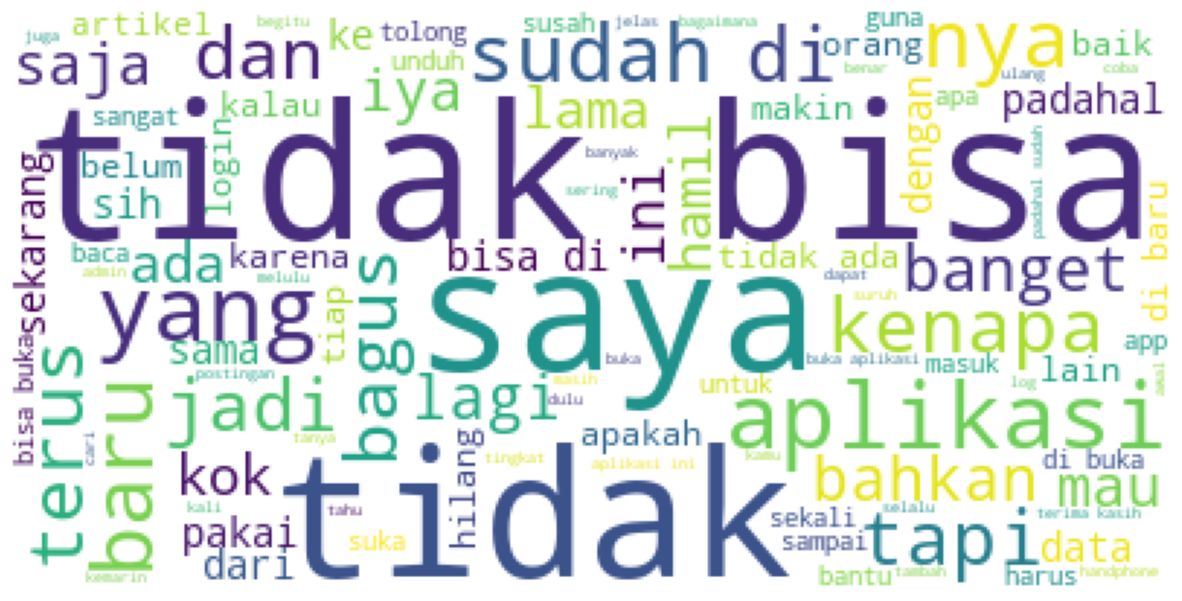

In [253]:
fig = plt.figure(figsize=(15,12))
word_cloud = WordCloud(background_color='white', max_font_size=80, max_words=100).generate(' '.join(corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Most Frequent Words

In [254]:
counter = Counter()

for i in tqdm(range(len(df_aft_covid['processed_tokenized']))):
  for word in df_aft_covid['processed_tokenized'].iloc[i]:
      counter[word] += 1


counter = dict(counter)

100%|██████████| 316/316 [00:00<00:00, 56392.80it/s]


In [255]:
# 10 most frequent words from corpus

top_10_words = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])
words = [x for x in top_10_words.keys()]
counts = [x for x in top_10_words.values()]
data = {'words': words, 'counts': counts}
top_10_words = pd.DataFrame(data, columns=['words', 'counts'])
top_10_words

,words,counts
0,tidak,194
1,bisa,120
2,di,110
3,aplikasi,92
4,saya,74
5,baru,71
6,yang,66
7,sudah,64
8,kenapa,52
9,nya,52


C:\Users\GF63\AppData\Local\Temp\ipykernel_13176\3317012872.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


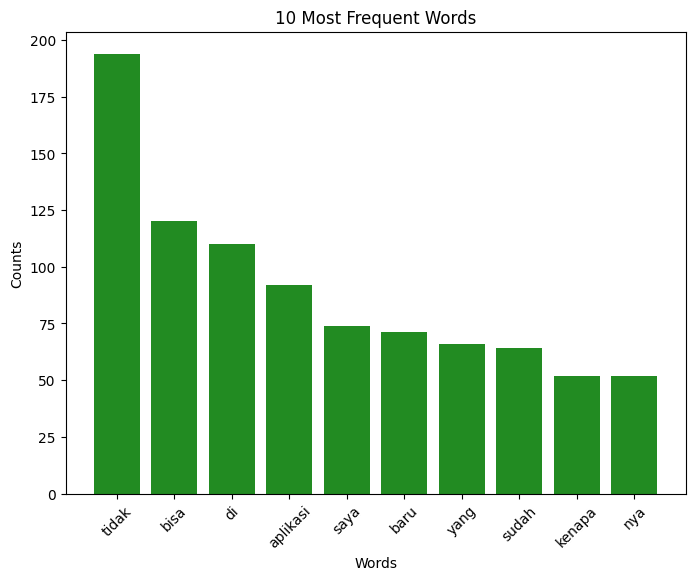

In [256]:
# plot

fig = plt.figure(figsize=(8,6))
plt.bar(top_10_words['words'], top_10_words['counts'], color='forestgreen')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('10 Most Frequent Words')
plt.legend().set_visible(False)
plt.show()

# Export

In [257]:
df_aft_covid['final_sentence'] = df_aft_covid['processed_tokenized'].apply(lambda words: ' '.join(words))
df_aft_covid

,review,processed_review,processed_words,tokenized_words,processed_tokenized,final_sentence
2,Mentok mulu di PIN stiap mau log in ga bisa ms...,mentok mulu di pin stiap mau log in ga bisa ms...,mentok melulu di pin setiap mau log in tidak b...,"[mentok, melulu, di, pin, setiap, mau, log, in...","[mentok, melulu, di, pin, tiap, mau, log, in, ...",mentok melulu di pin tiap mau log in tidak bis...
14,Baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalu bangus yah tak kasih 5,baru mau coba kalau bangus ya tidak kasih 5,"[baru, mau, coba, kalau, bangus, ya, tidak, ka...","[baru, mau, coba, kalau, bangus, ya, tidak, ka...",baru mau coba kalau bangus ya tidak kasih 5
43,Loading splash screennya lama. Harus restart H...,loading splash screennya lama harus restart hp...,loading splash screennya lama harus restart ha...,"[loading, splash, screennya, lama, harus, rest...","[loading, splash, screennya, lama, harus, rest...",loading splash screennya lama harus restart ha...
89,Rubbish,rubbish,rubbish,[rubbish],[rubbish],rubbish
127,So many rules!! So difficult for sharing!,so many rules so difficult for sharing,sok many rules sok difficult for sharing,"[sok, many, rules, sok, difficult, for, sharing]","[sok, many, rules, sok, difficult, for, sharing]",sok many rules sok difficult for sharing
...,...,...,...,...,...,...
9836,Knp hrus d update??,knp hrus d update,kenapa harus di pembaruan,"[kenapa, harus, di, pembaruan]","[kenapa, harus, di, baru]",kenapa harus di baru
9840,"Tiap saat update, bagusan yg awal². Lebih nnyaman",tiap saat update bagusan yg awal² lebih nnyaman,tiap saat pembaruan bagusan yang awal² lebih n...,"[tiap, saat, pembaruan, bagusan, yang, awal², ...","[tiap, saat, baru, bagus, yang, awal, lebih, n...",tiap saat baru bagus yang awal lebih nnyaman
9844,Baru nyoba,baru nyoba,baru mencoba,"[baru, mencoba]","[baru, coba]",baru coba
9851,Ga bisa di instal,ga bisa di instal,tidak bisa di instal,"[tidak, bisa, di, instal]","[tidak, bisa, di, instal]",tidak bisa di instal


In [258]:
df_aft_covid['processed_tokenized'].to_csv('export/tokenized_processed_df.csv', index=False, header=False)
df_aft_covid['final_sentence'].to_csv('export/processed_df.csv', index=False, header=False)